model-based Double deep q learning

 

In [ ]:
import gymnasium as gym
import jax
import jax.numpy as jnp
import numpy as np
from collections import deque
import random
from flax import linen as nn
import optax
import matplotlib 
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import os
import pandas as pd
import json
from typing import Callable, List, Tuple, Union

In [ ]:
# need a virtual display for rendering in docker
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
from IPython import display as ipythondisplay

In [ ]:
"""
class SimpleDense(nn.Module):
  features: int
  kernel_init: Callable = nn.initializers.lecun_normal()
  bias_init: Callable = nn.initializers.zeros_init()

  @nn.compact
  def __call__(self, inputs):
    kernel = self.param('kernel',
                        self.kernel_init, # Initialization function
                        (inputs.shape[-1], self.features))  # shape info.
    y = lax.dot_general(inputs, kernel,
                        (((inputs.ndim - 1,), (0,)), ((), ())),) # TODO Why not jnp.dot?
    bias = self.param('bias', self.bias_init, (self.features,))
    y = y + bias
    return y
"""
class LSSM(nn.Module):
    state_dim: int 
    action_dim: int
    disturbancce_dim: int
    output_dim: int
    dt: float 

    initializer: Callable = nn.initializers.lecun_normal()
    @nn.compact
    def __call__(self, x, u, d):
      """
      x: (b, state_dim)
      u: (b, action_dim)
      d: (b, disturbance_dim)
      """
      A = self.param('A',
                      self.initializer, # initialization
                      (self.state_dim, self.state_dim)) # shape
      Bu = self.param('Bu',
                      self.initializer, # initialization
                      (self.state_dim, self.action_dim))
      Bd = self.param('Bd',
                      self.initializer,
                      (self.state_dim, self.disturbancce_dim))

      C = self.param('C',
                      self.initializer,
                      (self.output_dim, self.state_dim))
      D = self.param("D",
                      self.initializer,
                      (self.output_dim, self.action_dim))
      xdot = jnp.dot(x, A.T) + jnp.dot(u, Bu.T) + jnp.dot(d, Bd.T)

      x_next = xdot * self.dt + x
      y_next = jnp.dot(x_next, C.T) + jnp.dot(u, D.T)
      
      return xdot, x_next, y_next

lssm = LSSM(state_dim=3, action_dim=1, disturbancce_dim=4, output_dim=2, dt=900.)

key1, key2 = jax.random.split(jax.random.PRNGKey(0), 2)
x = jax.random.uniform(key1, (3,3))
u = jnp.array([[0.],[0.],[0.]])
d = jax.random.uniform(key1, (3,4))
params = lssm.init(key2, x, u, d)
xdot, x_next, y_next = lssm.apply(params, x, u, d)
xdot
x_next
y_next

In [ ]:
# say we have an extact model of the system
A = np.array([[-1.97402551e-04,  0.00000000e+00,  1.92610415e-04],
              [0.00000000e+00, -3.30784418e-06,  2.00281620e-06],
              [1.51360733e-06,  7.56564853e-07, -2.27017218e-06]])
Bu = np.array([[9.63095932e-05], [0.], [0.]])
Bd = np.array([[4.79213586e-06, 9.63095932e-05, 0.00000000e+00, 0.00000000e+00],
               [1.30502798e-06, 0.00000000e+00, 2.00353963e-06, 0.00000000e+00],
               [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.56838127e-07]])
C = np.array([[1., 0., 0.],
              [0., 0., 0.]])
D = np.array([[0.],
              [1.]])

ABCD = {'A': A, 'Bu': Bu, 'Bd': Bd, 'C': C, 'D': D}
exact_model_params = {"params": ABCD}

# define the system
x0 = np.array([19,36,25])
u = 0
d = np.array([0,0,0,0])
dt = 900

# simulate the system
lssm = LSSM(state_dim=3, action_dim=1, disturbancce_dim=4, output_dim=2, dt=dt)
lssm.apply(exact_model_params, x0, u, d)


In [ ]:
class QNetwork(nn.Module):
    action_size: int
    
    def setup(self):
        self.dense1 = nn.Dense(features=256)
        self.dense2 = nn.Dense(features=256)
        self.dense3 = nn.Dense(features=256)
        self.dense4 = nn.Dense(features=self.action_size)

    def __call__(self, x):
        x = nn.relu(self.dense1(x))
        x = nn.relu(self.dense2(x))
        x = nn.relu(self.dense3(x))
        x = self.dense4(x)
        return x

In [ ]:
class DDQNAgent:
    def __init__(self, state_size, action_size, rng_key, buffer_size=10000, batch_size=64, gamma=0.99, lr=1e-3, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.99):
        self.state_size = state_size
        self.action_size = action_size
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.lr = lr
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.memory = deque(maxlen=buffer_size)

        rng_key, rng_key_init = jax.random.split(rng_key)
        self.network, self.params, self.optimizer, self.opt_state = self.initialize_network_and_optimizer(rng_key_init)
        self.target_params = self.params
        self.tau = 0.001
        self.steps = 0

        # debug
        self.losses = []
        self.grads = []
    
    def initialize_network_and_optimizer(self, rng):
        network = QNetwork(self.action_size)
        params = network.init(rng, jnp.ones((self.state_size,)))
        optimizer = optax.adam(self.lr)
        opt_state = optimizer.init(params)
        return network, params, optimizer, opt_state

    def sync_target(self):
        #self.target_params = self.params
        # this is soft update for each step
        self.target_params = jax.tree_map(lambda x, y: self.tau * x + (1 - self.tau) * y, self.params, self.target_params)

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randint(0, self.action_size - 1)
        else:
            state = jnp.expand_dims(jnp.array(state, dtype=jnp.float32), axis=0)
            q_values = self.network.apply(self.params, state)
            return int(jnp.argmax(q_values))

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def loss_fcn(self, params, states, actions, rewards, next_states, dones):
        # (s,a,r,s')
        # Q(s)
        q_values = self.network.apply(params, states)
        # Q(s,a)
        q_values = jnp.take_along_axis(q_values, actions[:, None], axis=-1).squeeze()#jax.vmap(lambda s: s[actions])(q_values)

        # Q(s')
        online_q_next = self.network.apply(params, next_states)
        # Q'(s')
        target_q_next = self.network.apply(self.target_params, next_states)
        
        # a' = argmax_a(Q(s'))
        next_action = jnp.argmax(online_q_next, axis=-1)
        # Q'(s', a')
        q_target_next = jnp.take_along_axis(target_q_next, next_action[:, None], axis=-1).squeeze()
        # target: r + gamma*Q'(s', a')
        targets = rewards + self.gamma * (1 - dones) * q_target_next
        
        return jnp.mean((targets - q_values) ** 2)
    
    def q_learning_update(self, states, actions, rewards, next_states, dones):

        grad_fn = jax.value_and_grad(self.loss_fcn)
        loss_value, gradients = grad_fn(self.params, states, actions, rewards, next_states, dones)
        updates, self.opt_state = self.optimizer.update(gradients, self.opt_state)
        self.params = optax.apply_updates(self.params, updates)
        self.losses.append(loss_value)
        self.grads.append(gradients)
        #self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
        #print(self.epsilon)
        #self.steps += 1

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))

        states = jnp.array(states, dtype=jnp.float32)
        actions = jnp.array(actions, dtype=jnp.int32)
        rewards = jnp.array(rewards, dtype=jnp.float32)
        next_states = jnp.array(next_states, dtype=jnp.float32)
        dones = jnp.array(dones, dtype=jnp.float32)

        self.q_learning_update(states, actions, rewards, next_states, dones)

    # auxillary function for model-based plannig
    def get_objective_batch(self, t, Tz, P, env):
        t = t.astype(jnp.int32)
        h = (t%86400/3600).astype(jnp.int32)

        price = env.energy_price
        Tz_ub = env.Tz_high
        Tz_lb = env.Tz_low 

        price_batch = jnp.array([price[i] for i in h])
        cost_batch = price_batch*P*env.dt/3600.
        Tz_high_batch = jnp.array([Tz_ub[i] for i in h])
        Tz_low_batch = jnp.array([Tz_lb[i] for i in h])

        dTz = jnp.fmax(Tz - Tz_high_batch, Tz_low_batch - Tz)
        dTz = jnp.fmax(dTz, 0)

        du = 0

        return -(env.weights[0]*cost_batch + env.weights[1]*dTz + env.weights[2]*du)


    def planning(self, env_model, env_model_params, horizon=10, env = None):
        # state is a numpy array
        # returns a numpy array of actions
        # this is a random action
        if len(self.memory) >= self.batch_size:
            return
        
        for _ in range(horizon):
            planning_batch = random.sample(self.memory, self.batch_size)
            t_batch = jnp.array([t for (t, _, _, _, _, _) in planning_batch])
            state_batch = jnp.array([s for (_, s, _, _, _, _) in planning_batch]) # random sample for states
            # random actions for exploration
            # choose from previously observed actions
            # action_batch = jnp.array([a for (_, a, _, _, _) in batch]) # random sample for actions
            # choose from action space
            action_batch = jnp.array([random.choice(range(self.action_size)) for _ in range(self.batch_size)])
            # disctete action to control inputs
            control_batch = jnp.array([action/(self.action_size-1)*(env.u_high - env.u_low) + env.u_low for action in action_batch])
            
            #state_action_batch = jnp.concatenate([state_batch, action_batch[:, np.newaxis]], axis=1)
            disturbance_batch = env.dist_fcn.evaluate(t_batch)
            
            # DRL state batch to model state batch
            model_state_batch = state_batch[:, 1:4] # [Tz, Twe, Twi]
            _, x_predictions, y_predictions = env_model.apply(env_model_params, model_state_batch, control_batch, disturbance_batch)
            # next_state_batch, reward_batch = env_model.apply(env_model_params, state_action_batch)
            # reconstruct next-state batch
            next_state_batch = jnp.concatenate([next_state_batch[:,0].reshape(-1,1), x_predictions, next_state_batch[:,4:6], -y_predictions[:,1].reshape(-1,1), next_state_batch[:,7:]], axis=1)
            
            # reconstruct reward batch: we avoid du in objective, otherwise we have to save previous action in memeory
            Tz = y_predictions[:,0]
            P = -y_predictions[:,1]
            
            reward_batch = self.get_objective_batch(t_batch, Tz, P, env)
            
            done_batch = jnp.full(reward_batch.shape, False, dtype=jnp.float32)
            #done_batch = (jnp.abs(jnp.sum(next_state_batch - state_batch, axis=1)) > 0.5).astype(jnp.float32)

            self.q_learning_update(state_batch, action_batch, reward_batch, next_state_batch, done_batch)
    


In [ ]:
# RC model parameters
rc_params = [6.9789902e+03, 2.1591113e+04, 1.8807944e+05, 3.4490612e+00, 4.9556872e-01, 9.8289281e-02, 4.6257420e+00]
x0 = np.array([20, 35.8, 26.])
x_high = np.array([40., 80., 40.])
x_low = np.array([10., 10., 10.])
n_actions = 101
u_high = [0]
u_low = [-10.0] # -12

# load disturbances
file_path = os.path.abspath('')
parent_path = os.path.dirname(file_path)
data_path = os.path.join(parent_path, 'data/disturbance_1min.csv')
data = pd.read_csv(data_path, index_col=[0])
# assign time index
t_base = 181*24*3600 # 7/1
n = len(data)
index = range(t_base, t_base + n*60, 60)
data.index = index

# sample
dt = 900
data = data.groupby([data.index // dt]).mean()
index_dt = range(t_base, t_base + len(data)*dt, dt)
data.index = index_dt 

# get disturbances for lssm
t_d = index_dt
disturbance_names = ['out_temp', 'qint_lump', 'qwin_lump', 'qradin_lump']
disturbance = data[disturbance_names].values


/opt/conda/lib/python3.8/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


env is reset!
Episode 0, Total Reward: -883.5287999999999
env is reset!
Episode 1, Total Reward: -871.7769749999998
env is reset!
Episode 2, Total Reward: -699.6602646548138
env is reset!
Episode 3, Total Reward: -844.2873999999999
env is reset!
Episode 4, Total Reward: -806.5220499999999
env is reset!
Episode 5, Total Reward: -749.5648749999998
env is reset!
Episode 6, Total Reward: -671.1305249999996
env is reset!
Episode 7, Total Reward: -571.0500818929438
env is reset!
Episode 8, Total Reward: -705.981529475542
env is reset!
Episode 9, Total Reward: -754.0217499999999
env is reset!
Episode 10, Total Reward: -628.6186201164098
env is reset!
Episode 11, Total Reward: -594.1573723467114
env is reset!
Episode 12, Total Reward: -561.8678777325158
env is reset!
Episode 13, Total Reward: -497.69626153642514
env is reset!
Episode 14, Total Reward: -508.1825429999767
env is reset!
Episode 15, Total Reward: -452.990477408564
env is reset!
Episode 16, Total Reward: -452.10262746393704
env is 

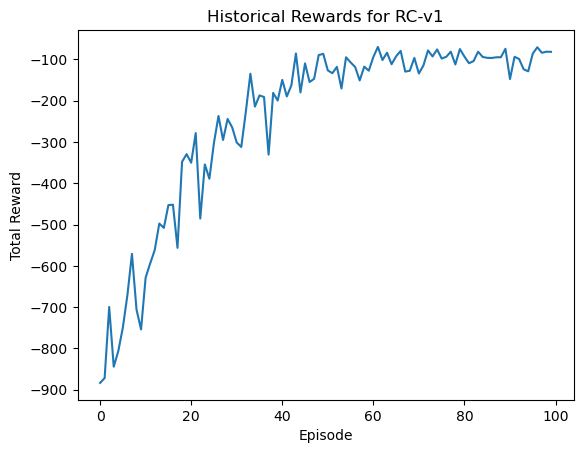

In [ ]:
# random seed
seed = 0
np.random.seed(seed)

# Train the agent
import env
ts = 195*24*3600
ndays = 1
te = ndays*24*3600 + ts
weights = [100., 1., 0.] # for energy cost, dT, du
cop = 1.0

env = gym.make("R4C3Discrete-v0",
            rc_params = rc_params,
            x0 = x0,
            x_high = x_high,
            x_low = x_low,
            n_actions = n_actions,
            u_high = u_high,
            u_low = u_low,
            disturbances = (t_d, disturbance),
            cop = cop,
            ts = ts,
            te = te,
            dt = dt,
            weights = weights).env

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
rng_key = jax.random.PRNGKey(42) 
lr = 1e-05
epsilon_decay = 0.98
planning_steps = 5

agent = DDQNAgent(state_size, action_size, rng_key, lr=lr, epsilon_decay=epsilon_decay)

# specify environment model:  
env_model = LSSM(state_dim=3, action_dim=1, disturbancce_dim=4, output_dim=2, dt=dt)
env_model_params = exact_model_params

# hyperparameters
n_episodes = 100
reward_history = []
max_episode_steps=200 # env.spec.max_episode_steps
reward_threshold= -10 # env.spec.reward_threshold
solved_window = 20
 
# sync target q-network
steps_since_target_update = 0
target_update_freq = 5

# main loop
for episode in range(n_episodes):
    state, _ = env.reset(seed=0)
    state = jnp.array(state, dtype=jnp.float32)

    total_reward = 0
    done = False
    step_in_episode = 0
    
    while not done:
        action = agent.act(state)
        next_state, reward, done, _, _ = env.step(action)
        next_state = jnp.array(next_state, dtype=jnp.float32)

        agent.remember(state, action, reward, next_state, done)
        agent.replay()
        agent.planning(env_model, env_model_params, planning_steps, env)
        
        state = next_state
        total_reward += reward
        step_in_episode += 1

        # update  target q-network 
        steps_since_target_update += 1
        if steps_since_target_update >= target_update_freq:
            agent.sync_target()
            steps_since_target_update = 0
  
        # udpate epsiolon after episode
        if done:
            if agent.epsilon > agent.epsilon_end:
                agent.epsilon *= agent.epsilon_decay
    
    reward_history.append(total_reward)
    print(f"Episode {episode}, Total Reward: {total_reward}")

    # stop training if average reward reaches requirement
    # Calculate the average reward over the last 'solved_window' episodes
    if episode >= solved_window:
        avg_reward = np.mean(reward_history[-solved_window:])
        print(f'Episode: {episode}, Average Reward: {avg_reward}')

        if avg_reward >= reward_threshold:
            print(f"RC solved in {episode} episodes!")
            break

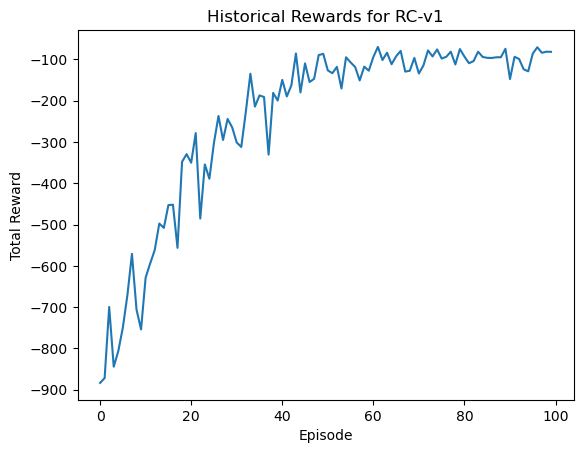

In [ ]:
# save rewards
with open('./ddqn-rc-reward.json', 'w') as f:
    json.dump(reward_history, f)

# Plot the historical rewards
plt.figure()
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Historical Rewards for RC-v1")
plt.savefig('ddqn-rc-reward.pdf')


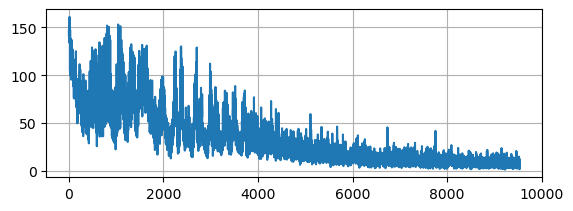

In [ ]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(agent.losses)
plt.grid()
plt.savefig('ddqn-rc-losses.png')

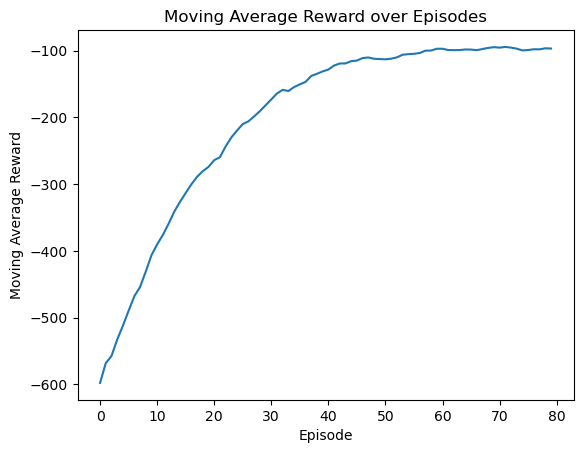

In [ ]:
# plot training 
def plot_moving_average_reward(episode_rewards, window_size=20):
    cumsum_rewards = np.cumsum(episode_rewards)
    moving_avg_rewards = (cumsum_rewards[window_size:] - cumsum_rewards[:-window_size]) / window_size

    plt.plot(moving_avg_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Moving Average Reward')
    plt.title('Moving Average Reward over Episodes')
    plt.savefig('ddqn-rc-ma-reward.png')

plot_moving_average_reward(reward_history)


In [ ]:
# need a virtual display for rendering in docker
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
from IPython import display as ipythondisplay

# Test the trained agent

print("\nTesting the trained agent...")
state, _ = env.reset(seed=0)
state = jnp.array(state, dtype=jnp.float32)

total_reward = 0
done = False
pre_screen = env.render()
step_in_episode = 0
actions = []
Tz = [state[1]]
P = [state[6]]
To = [state[4]]

while not done:
    agent.epsilon = 0
    action = agent.act(state)
    next_state, reward, done, _, _ = env.step(action)
    next_state = jnp.array(next_state, dtype=jnp.float32)
    state = next_state
    total_reward += reward
    step_in_episode += 1

    # save for future use
    actions.append(action)
    Tz.append(next_state[1])
    P.append(next_state[6])
    To.append(next_state[4])
print(f"Total Reward: {total_reward}")

env.close()


Testing the trained agent...
env is reset!
Total Reward: -87.2718800105325


1


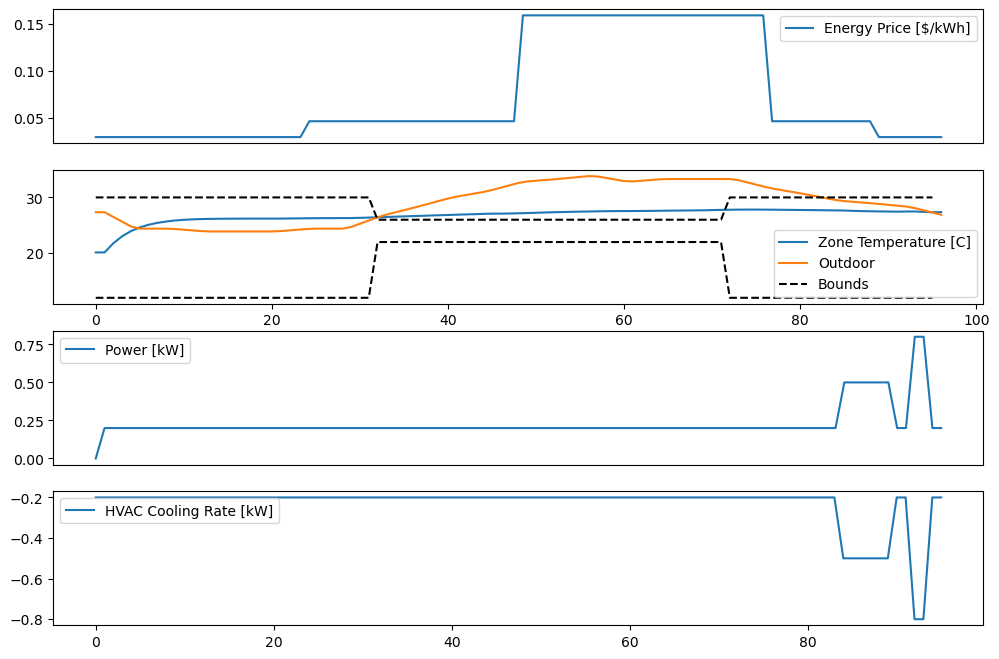

In [ ]:

n_days = step_in_episode*dt // (3600*24)
n_steps_per_hour = 3600 // dt
prices = env.energy_price
Tub = env.Tz_high
Tlb = env.Tz_low


# need make sure the length of Tub and Tlb is the same as Tz
prices = np.tile(prices.reshape(-1,1), (n_days, n_steps_per_hour))
Tub = np.tile(np.array(Tub).reshape(-1, 1), (n_days, n_steps_per_hour)) 
Tlb = np.tile(np.array(Tlb).reshape(-1, 1), (n_days, n_steps_per_hour)) 
# actions to actual cooling rate 
actions = [action/(n_actions-1)*(np.array(u_high) - np.array(u_low)) + np.array(u_low) for action in actions]

print(n_days)
plt.figure(figsize=(12,8))
plt.subplot(4,1,1)
plt.plot(prices.flatten(), label='Energy Price [$/kWh]')
plt.xticks([])
plt.legend() 

plt.subplot(4,1,2)
plt.plot(Tz, label='Zone Temperature [C]')
plt.plot(To, label="Outdoor")
plt.plot(Tub.flatten(), 'k--', label='Bounds')
plt.plot(Tlb.flatten(), 'k--')
plt.legend()

plt.subplot(4,1,3)
plt.plot(P, label="Power [kW]")
plt.xticks([])
plt.legend()

plt.subplot(4,1,4)
plt.plot(actions, label="HVAC Cooling Rate [kW]")
plt.legend()
plt.savefig('ddqn-rc.png')